## Training StyleGAN - CelebA

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
BATCH_SIZE = 32
LR = 1e-5
NUM_EPOCHES = 40
CRIT_REPEATS = 4

## Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [6]:
dataroot = "../data/celeba/"

dataset = datasets.ImageFolder(root=dataroot, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [7]:
from models.StyleGAN import StyleGAN_Generator, StyleGAN_Discriminator

In [8]:
in_channels = 256
out_channels = 3
hidden_channels = 512
z_dim = 128
mapping_hidden_size = 256
w_dim = 512
kernel_size=3

in_size = 3
d_hidden_size = 16

g = StyleGAN_Generator(in_channels, out_channels, hidden_channels, z_dim, mapping_hidden_size, w_dim, kernel_size, device=DEVICE).to(DEVICE)
d = StyleGAN_Discriminator(in_size, d_hidden_size).to(DEVICE)
print(g)
print(d)

from utils.model import weights_init 

g = g.apply(weights_init)
d = d.apply(weights_init)

StyleGAN_Generator(
  (mapping_network): MappingNetwork(
    (mapping_network): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): ReLU()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): ReLU()
      (10): Linear(in_features=256, out_features=512, bias=True)
    )
  )
  (block0): SynthesisNetwork_Block(
    (injectnoise): InjectNoise()
    (convolution): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (adain): AdaIN(
      (normalize): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (style_scale): Linear(in_features=512, out_features=512, bias=True)
      (style_shift): Linear(in_features=512, out_features=512, bias=

In [9]:
for index, (real, _) in enumerate(dataloader):
    real = real.to(DEVICE)
    noise = torch.randn(real.size(0), z_dim).to(DEVICE)
    
    print("Input Image Dimensions: {}".format(real.size()))
    print("Noise Dimensions: {}".format(noise.size()))
    print("-"*100)
    
    fake = g(noise)
    pred = d(fake)
    
    print("Fake Output Dimensions: {}".format(fake.size()))
    print("Prediction Output Dimensions: {}".format(pred.size()))
    break

Input Image Dimensions: torch.Size([32, 3, 64, 64])
Noise Dimensions: torch.Size([32, 128])
----------------------------------------------------------------------------------------------------


C:\Users\Udbhav Prasad\anaconda3\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Fake Output Dimensions: torch.Size([32, 3, 64, 64])
Prediction Output Dimensions: torch.Size([32, 4])


## Training

In [10]:
from Loss_F.loss import W_Crit_Loss, W_Gen_Loss

w_crit_loss = W_Crit_Loss(10)
w_gen_loss = W_Gen_Loss()
g_optimizer = torch.optim.Adam(g.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=LR, betas=(0.5, 0.999))

Step 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


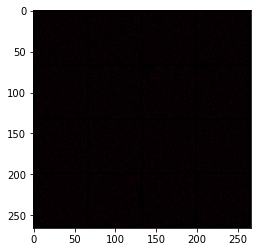

In [ ]:
from utils.train import Wasserstein_Crit_Train

loss_hist = {}
loss_hist["generator loss"] = []
loss_hist["discriminator loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    
    epoch_d_loss = 0
    epoch_g_loss = 0
    
    for index, (real, _) in enumerate(dataloader):
        b = real.size(0)
        real = real.to(DEVICE)
        
        loss = Wasserstein_Crit_Train(d, g, d_optimizer, w_crit_loss, CRIT_REPEATS, real, z_dim, device=DEVICE)
        epoch_d_loss += loss
        
        g_optimizer.zero_grad()
        noise = torch.randn(b, z_dim).to(DEVICE)
        fake = g(noise)
        pred = d(fake)
        
        g_loss = w_gen_loss(pred)
        g_loss.backward()
        epoch_g_loss += g_loss.item()
        g_optimizer.step()
        
        if index%400 == 0:
            g.eval()
            print("Step {}".format(index))
            noise = torch.randn(b, z_dim).to(DEVICE)
            fake = g(noise)
    
            images = fake.detach().to("cpu")
            images_grid = make_grid(images[:16], nrow=4)
            g.train()
            plt.imshow(images_grid.permute(1, 2, 0).squeeze())
            plt.show()
        
    epoch_g_loss /= len(dataloader)
    epoch_d_loss /= len(dataloader)
    
    loss_hist["generator loss"].append(epoch_g_loss)
    loss_hist["discriminator loss"].append(epoch_d_loss)
    
    print("Epoch {}: Generator Loss: {}; Discriminator Loss: {}".format(epoch, epoch_g_loss, epoch_d_loss))